## Imports

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import os
import re

In [ ]:

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

## Function Definition

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, roc_curve
def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
    y_true (array): True binary labels.
    y_pred (array): Predicted probabilities.
    min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
    float: Scaled pAUC value.
    """
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = np.array([1.0 - x for x in y_pred])  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc


## Model Definition

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(65536, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Hyperparams

In [ ]:

batch_size = 32
learning_rate = 0.0001
num_epochs = 30
num_classes = 2 
dropout_rate = 0.0

## Dataset Processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(root='../data/balanced_data', transform=transform)
num_classes = len(dataset.classes)


train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    [label for _, label in dataset.samples],
    test_size=0.2,
    stratify=[label for _, label in dataset.samples],
    random_state=42
)

val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


train_dataset = Subset(dataset, train_indices)
train_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
train_augmented_indices = np.random.choice(train_indices, size=len(train_indices), replace=False)
train_augmented_dataset = Subset(train_augmented_dataset, train_augmented_indices)
train_combined_dataset = ConcatDataset([train_dataset, train_augmented_dataset])

val_dataset = Subset(dataset, val_indices)
val_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
val_augmented_indices = np.random.choice(val_indices, size=len(val_indices), replace=False)
val_augmented_dataset = Subset(val_augmented_dataset, val_augmented_indices)
val_combined_dataset = ConcatDataset([val_dataset, val_augmented_dataset])

test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Init Model

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Test

In [ ]:

saved_models_dir = "saved_models_1STAR"
best_model_path = os.path.join(saved_models_dir, "best_model.pth")


if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"No model file found at {best_model_path}.")


print(f"Loading the best model: {best_model_path}")
model.load_state_dict(torch.load(best_model_path))
model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        
        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = torch.argmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


pAUC = custom_metric(np.array(all_labels), np.array(all_probs), min_tpr=0.8)
print(f"Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): {pAUC:.4f}")


Loading the best model: saved_models_1STAR\best_model.pth
Test Loss: 0.4588, Test Accuracy: 0.7595
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        40
           1       0.86      0.62      0.72        39

    accuracy                           0.76        79
   macro avg       0.78      0.76      0.75        79
weighted avg       0.78      0.76      0.75        79

Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): 0.0976


C:\Users\jonec\AppData\Local\Temp\ipykernel_68964\1630096397.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


## Plotting

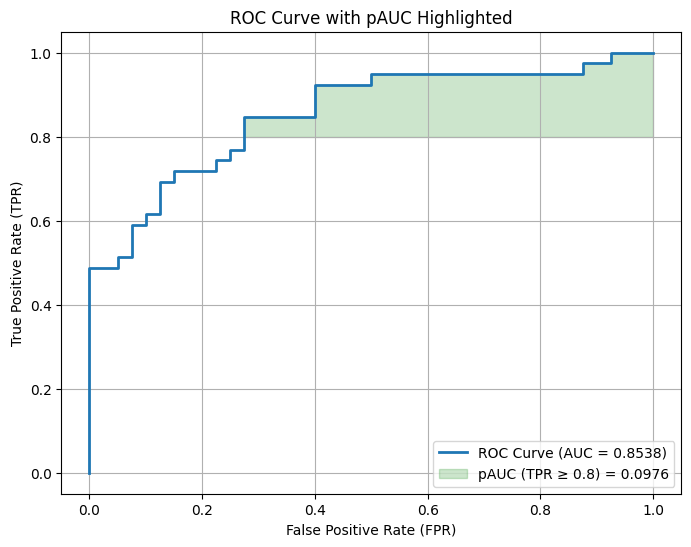

ROC Curve plot saved to saved_models_1STAR\roc_curve_with_pauc.png


In [35]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)

# Plot the main ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(all_labels, all_probs):.4f})", linewidth=2)

# Define TPR threshold
tpr_threshold = 0.8

# Interpolate FPR at TPR = 0.8
fpr_interp = np.interp(tpr_threshold, tpr, fpr)

# Find indices where TPR >= 0.8
valid_indices = tpr >= tpr_threshold

# Create bounded arrays for the shaded region
fpr_bounded = np.concatenate(([fpr_interp], fpr[valid_indices]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[valid_indices]))

# Highlight the green area bounded by TPR = 0.8 and the curve
plt.fill_between(
    fpr_bounded,
    tpr_bounded,
    tpr_threshold,
    color="green",
    alpha=0.2,
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {pAUC:.4f}"
)

# Finalize the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with pAUC Highlighted')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot
roc_plot_path = os.path.join(saved_models_dir, "roc_curve_with_pauc.png")
plt.savefig(roc_plot_path, bbox_inches="tight")
plt.show()

print(f"ROC Curve plot saved to {roc_plot_path}")
